<a href="https://colab.research.google.com/github/geohead/Cassini-to-UTM-conversion-workflow-/blob/main/Cassini_To_UTM_convertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the code below to upload your CSV file with a list of 4 Cassini coordinates with their corresponding UTM coordinates or sheet corners. As shown in the image below.**


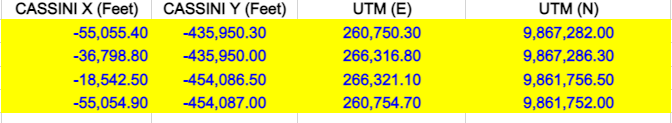


In [ ]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving kilifi.csv to kilifi (1).csv
kilifi.csv


In [ ]:
import pandas as pd
import io



def getCommonPoints(csv_path):
  data = pd.read_csv(io.StringIO(uploaded[csv_path].decode('utf-8')))
  columns =data.columns.tolist()

  cassini_x = data[columns[0]].tolist()
  cassini_y = data[columns[1]].tolist()
  utm_x = data[columns[2]].tolist()
  utm_y = data[columns[3]].tolist()
  
  return (cassini_x,cassini_y,utm_x,utm_y)
  
cp = (getCommonPoints(csv_path=filename))
df = pd.DataFrame(list(zip(cp[0],cp[1],cp[2],cp[3])),\
                  index=['1.','2.','3.','4.'],\
                  columns=['cassini_x','cassini_y','utm_x','utm_y'])
print (df)

In [ ]:
from math import pow
import numpy as np

parameters = {'a':20926348,'b':20855232.837}

zeros =[0,0,0,0]
ones = [1,1,1,1]

def columnMatrix (a,b):
  c = []
  for item in range (len(a)):
    c.append(a[item])
    c.append(b[item])
  c1 = np.array(c).reshape(8,1)
  return c1

def getFourParams (cassini_x,cassini_y,utm_x,utm_y):
  
  a1 = columnMatrix (a= cassini_x,b= cassini_y)
  a2 = columnMatrix (a= np.negative(cassini_y), b= cassini_x)
  a3 = columnMatrix (a= ones,b= zeros)
  a4 = columnMatrix (a= zeros,b= ones)
  
  A  = np.hstack((a1,a2,a3,a4))
  L  = columnMatrix (a= utm_x,b= utm_y)
  
  # perform actual linear algebra
  A_t =np.transpose (A)
  A_At = np.dot(A_t,A)
  AInv = np.linalg.inv(A_At) 
  A_tL =np.dot(A_t,L)
  four_param =np.dot(AInv,A_tL)
  return four_param

pts= getCommonPoints(csv_path=filename)
params =getFourParams(pts[0],pts[1],pts[2],pts[3])
print(params)

**Run the code in the cell below to upload your CSV file with a list of Cassini coordinates (X,Y) in feet, which you want to be transformed.** (Format as shown below.)

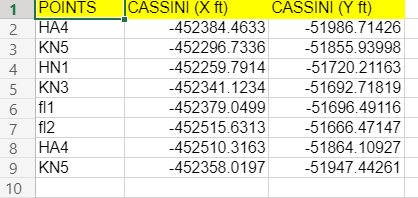



In [ ]:
from google.colab import files
uploaded = files.upload()
filename2 = next(iter(uploaded))

In [ ]:
def getCassiniPoints(csv_path):
  data = pd.read_csv(io.StringIO(uploaded[csv_path].decode('utf-8')))
  columns =data.columns.tolist()

  point_id = data[columns[0]].tolist()
  cassini_x = data[columns[1]].tolist()
  cassini_y = data[columns[2]].tolist()

  return (point_id,cassini_x,cassini_y)


p = getCassiniPoints(csv_path= filename2)

def get_eastings (four_param,cass_x,cass_y):
  e = four_param[0][0]* cass_x - four_param[1][0]*cass_y + four_param[2][0]
  return e

def get_northings (four_param,cass_x,cass_y):
  n = four_param[1][0]* cass_x + four_param[0][0]*cass_y + four_param[3][0]
  return n

xs =[];ys =[];

for n in range((len(p[0]))):
  
  x = get_eastings (params,(p[1][n]),(p[2][n]))
  xs.append(x)

  y = get_northings (params,(p[1][n]),(p[2][n]))
  ys.append(y)


df = pd.DataFrame(list(zip(p[0],xs,ys,)),columns =['Point','Eastings', 'Northings'])
pd.options.display.float_format = '{:.2f}'.format
print(df)


**Run the code below to download the results as a csv**

In [ ]:
df.to_csv('result.csv') 
files.download('result.csv')